# Microphone Cross-talk Cancellation Results Analysis

This notebook loads calibration results and generates comparative graphs similar to Das et al. (2021) Figure 2.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results
df = pd.read_csv('run/results.csv')
print("Available algorithms:")
print(df['alg'].unique())
print(f"\nTotal rows: {len(df)}")
df.head()

Available algorithms:
['mcwf_paper' 'mle_lambda0_paper' 'stft_v1' 'mcwf_v1']

Total rows: 20


,calc,alg,mic_d,src_d,ops,tps,ips,aps,room_config,sdr,sir,sar,timestamp
0,0,mcwf_paper,0.1,1.0,41.0,58.0,70.0,59.0,das2021_sim,NaN,NaN,NaN,2025-12-07T11:00:00
1,0,mcwf_paper,0.2,1.0,29.0,55.5,54.0,60.0,das2021_sim,NaN,NaN,NaN,2025-12-07T11:00:00
2,0,mcwf_paper,0.3,1.0,23.0,55.0,38.5,61.0,das2021_sim,NaN,NaN,NaN,2025-12-07T11:00:00
3,0,mcwf_paper,0.4,1.0,21.0,57.0,35.0,60.5,das2021_sim,NaN,NaN,NaN,2025-12-07T11:00:00
4,0,mcwf_paper,0.5,1.0,20.5,55.0,30.0,60.0,das2021_sim,NaN,NaN,NaN,2025-12-07T11:00:00


## Configuration

Select which algorithms to display in the graphs:

In [2]:
# ============================================
# CONFIGURE ALGORITHMS TO SHOW
# ============================================

# Uncomment/add lines to include algorithms in the comparison
ALGORITHMS_TO_SHOW = [
    'stft_v1',           # Our implementation
    'mcwf_paper',        # MCWF from Das et al. 2021
    'mle_lambda0_paper', # MLE (λ=1) from Das et al. 2021
    'mcwf_v1', # Our implementation
]

# ============================================
# STYLING OPTIONS
# ============================================

# Line styles and colors for each algorithm
ALGO_STYLES = {
    'stft_v1': {'color': '#2ecc71', 'marker': 'o', 'linestyle': '-', 'linewidth': 2.5, 'label': 'MLE λ=1 (Ours)'},
    'mcwf_paper': {'color': '#e74c3c', 'marker': 's', 'linestyle': '--', 'linewidth': 2, 'label': 'MCWF [Paper]'},
    'mle_lambda0_paper': {'color': '#3498db', 'marker': '^', 'linestyle': '-.', 'linewidth': 2, 'label': 'MLE λ=0 [Paper]'},
    'mcwf_v1': {'color': '#ff0000', 'marker': 's', 'linestyle': '-.', 'linewidth': 2, 'label': 'MCFW (Ours)'},
}

# Filter data
df_filtered = df[df['alg'].isin(ALGORITHMS_TO_SHOW)].copy()
print(f"Showing {len(df_filtered)} data points for {len(ALGORITHMS_TO_SHOW)} algorithms")

Showing 20 data points for 4 algorithms


## PEASS Metrics vs Source-Microphone Distance

Replicating Figure 2 from Das et al. (2021): Four subplots showing OPS, TPS, IPS, APS vs source-microphone distance.

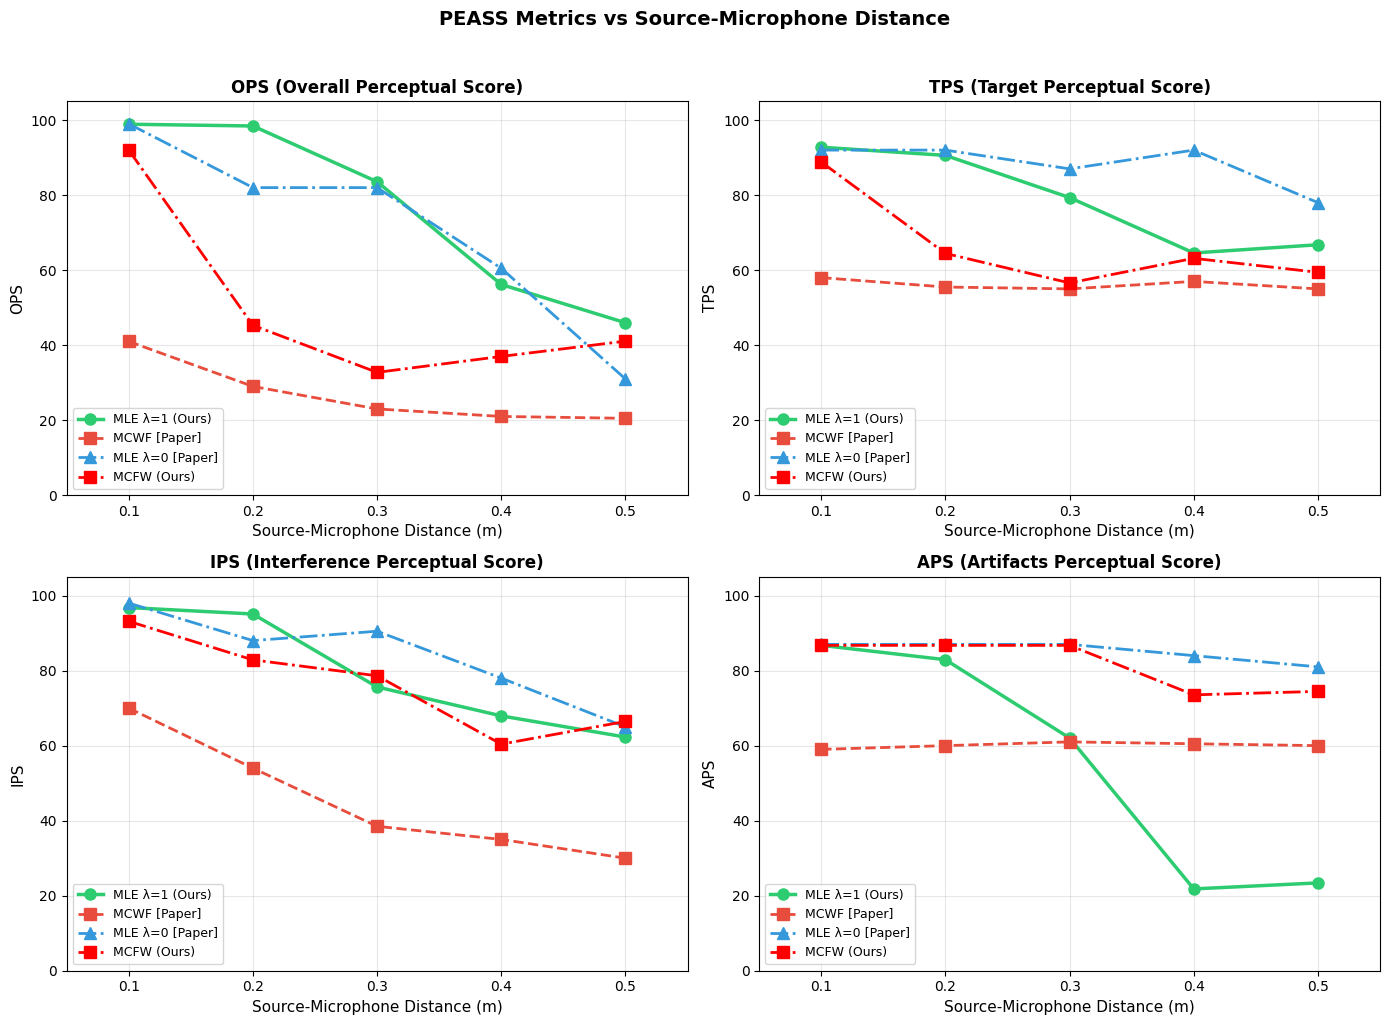

Saved to run/peass_comparison.png


In [3]:
def plot_peass_metrics(df, algorithms, styles, figsize=(14, 10)):
    """Generate a 2x2 grid of PEASS metrics vs mic distance."""
    
    metrics = ['ops', 'tps', 'ips', 'aps']
    titles = [
        'OPS (Overall Perceptual Score)',
        'TPS (Target Perceptual Score)',
        'IPS (Interference Perceptual Score)',
        'APS (Artifacts Perceptual Score)'
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        
        for alg in algorithms:
            alg_data = df[df['alg'] == alg].sort_values('mic_d')
            if len(alg_data) == 0:
                continue
            
            style = styles.get(alg, {'color': 'gray', 'marker': 'x', 'linestyle': '-', 'linewidth': 1.5, 'label': alg})
            
            ax.plot(
                alg_data['mic_d'],
                alg_data[metric],
                color=style['color'],
                marker=style['marker'],
                linestyle=style['linestyle'],
                linewidth=style['linewidth'],
                label=style['label'],
                markersize=8
            )
        
        ax.set_xlabel('Source-Microphone Distance (m)', fontsize=11)
        ax.set_ylabel(title.split('(')[0].strip(), fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlim(0.05, 0.55)
        ax.set_ylim(0, 105)
        ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower left', fontsize=9)
    
    plt.suptitle('PEASS Metrics vs Source-Microphone Distance', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Generate plot
fig = plot_peass_metrics(df_filtered, ALGORITHMS_TO_SHOW, ALGO_STYLES)
plt.savefig('run/peass_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved to run/peass_comparison.png")

## Single Metric Comparison (OPS)

A cleaner single-plot view focusing on the Overall Perceptual Score:

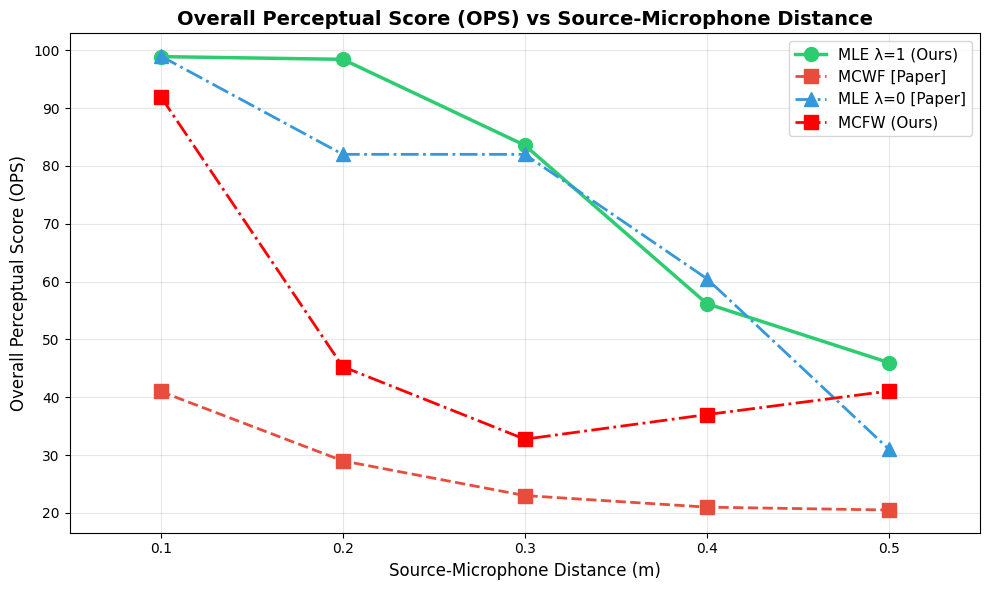

In [4]:
def plot_single_metric(df, algorithms, styles, metric='ops', figsize=(10, 6)):
    """Plot a single metric comparison."""
    
    metric_names = {
        'ops': 'Overall Perceptual Score (OPS)',
        'tps': 'Target Perceptual Score (TPS)',
        'ips': 'Interference Perceptual Score (IPS)',
        'aps': 'Artifacts Perceptual Score (APS)',
        'sdr': 'Source to Distortion Ratio (SDR) [dB]'
    }
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for alg in algorithms:
        alg_data = df[df['alg'] == alg].sort_values('mic_d')
        if len(alg_data) == 0:
            continue
        
        style = styles.get(alg, {'color': 'gray', 'marker': 'x', 'linestyle': '-', 'linewidth': 2, 'label': alg})
        
        ax.plot(
            alg_data['mic_d'],
            alg_data[metric],
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            linewidth=style['linewidth'],
            label=style['label'],
            markersize=10
        )
    
    ax.set_xlabel('Source-Microphone Distance (m)', fontsize=12)
    ax.set_ylabel(metric_names.get(metric, metric.upper()), fontsize=12)
    ax.set_title(f'{metric_names.get(metric, metric.upper())} vs Source-Microphone Distance', fontsize=14, fontweight='bold')
    ax.set_xlim(0.05, 0.55)
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    return fig

# Plot OPS comparison
fig = plot_single_metric(df_filtered, ALGORITHMS_TO_SHOW, ALGO_STYLES, metric='ops')
plt.savefig('run/ops_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Results Table

In [5]:
# Display formatted table
display_cols = ['alg', 'mic_d', 'ops', 'tps', 'ips', 'aps', 'sdr']
df_display = df_filtered[display_cols].copy()
df_display = df_display.sort_values(['alg', 'mic_d'])

# Round numeric columns
for col in ['ops', 'tps', 'ips', 'aps', 'sdr']:
    df_display[col] = df_display[col].round(2)

df_display

,alg,mic_d,ops,tps,ips,aps,sdr
0,mcwf_paper,0.1,41.00,58.00,70.00,59.00,NaN
1,mcwf_paper,0.2,29.00,55.50,54.00,60.00,NaN
2,mcwf_paper,0.3,23.00,55.00,38.50,61.00,NaN
3,mcwf_paper,0.4,21.00,57.00,35.00,60.50,NaN
4,mcwf_paper,0.5,20.50,55.00,30.00,60.00,NaN
15,mcwf_v1,0.1,92.00,88.83,93.15,86.73,inf
16,mcwf_v1,0.2,45.29,64.46,82.86,86.73,inf
17,mcwf_v1,0.3,32.75,56.59,78.62,86.73,inf
18,mcwf_v1,0.4,37.00,63.15,60.40,73.54,inf
19,mcwf_v1,0.5,41.07,59.42,66.45,74.46,inf


## SDR Comparison (BSS Eval Metric)

In [ ]:
# Only show algorithms that have SDR values
df_with_sdr = df_filtered[df_filtered['sdr'].notna() & (df_filtered['sdr'] != '') & (df_filtered['sdr'] != 'inf')].copy()
df_with_sdr['sdr'] = pd.to_numeric(df_with_sdr['sdr'], errors='coerce')
df_with_sdr = df_with_sdr.dropna(subset=['sdr'])

if len(df_with_sdr) > 0:
    algs_with_sdr = df_with_sdr['alg'].unique().tolist()
    fig = plot_single_metric(df_with_sdr, algs_with_sdr, ALGO_STYLES, metric='sdr', figsize=(10, 6))
    plt.savefig('run/sdr_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No SDR data available for selected algorithms")